# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [7]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [15]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [16]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [35]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the current/recent played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # every 2 steps
            if num_step%2 == 0:            
                # Rating and training the memory
                #rates = np.array(memory.buffer)[:, 5]
                #rated_mem = np.array(memory.buffer)[rates >= (max(rates)*0.1)]
                #rated_mem = np.array(memory.buffer)
                #batch = sample(ListArr=rated_mem, batch_size=batch_size)
                #batch = sample(ListArr=memory.buffer, batch_size=batch_size)
                batch = memory.sample(batch_size=batch_size)
                rates = np.array([each[5] for each in batch]) # rated memory
                states = np.array([each[0] for each in batch])[rates >= (max(rates)*0.2)]
                actions = np.array([each[1] for each in batch])[rates >= (max(rates)*0.2)]
                next_states = np.array([each[2] for each in batch])[rates >= (max(rates)*0.2)]
                rewards = np.array([each[3] for each in batch])[rates >= (max(rates)*0.2)]
                dones = np.array([each[4] for each in batch])[rates >= (max(rates)*0.2)]
                #rates = np.array([each[5] for each in batch])[rates >= (max(rates)*0.2)]
                #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
                next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
                nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
                targetQs = rewards + (gamma * nextQs)
                loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.targetQs: targetQs})
                loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:12.0000 R:12.0 rate:0.0240 loss:1.1580 exploreP:0.9988
Episode:1 meanR:13.5000 R:15.0 rate:0.0300 loss:1.2090 exploreP:0.9973
Episode:2 meanR:20.0000 R:33.0 rate:0.0660 loss:1.1930 exploreP:0.9941
Episode:3 meanR:20.0000 R:20.0 rate:0.0400 loss:1.2432 exploreP:0.9921
Episode:4 meanR:25.4000 R:47.0 rate:0.0940 loss:1.3014 exploreP:0.9875
Episode:5 meanR:25.8333 R:28.0 rate:0.0560 loss:1.3603 exploreP:0.9848
Episode:6 meanR:28.5714 R:45.0 rate:0.0900 loss:1.5196 exploreP:0.9804
Episode:7 meanR:26.8750 R:15.0 rate:0.0300 loss:1.6118 exploreP:0.9789
Episode:8 meanR:25.6667 R:16.0 rate:0.0320 loss:1.6684 exploreP:0.9774
Episode:9 meanR:25.0000 R:19.0 rate:0.0380 loss:1.6173 exploreP:0.9756
Episode:10 meanR:24.2727 R:17.0 rate:0.0340 loss:1.6524 exploreP:0.9739
Episode:11 meanR:24.9167 R:32.0 rate:0.0640 loss:1.8257 exploreP:0.9708
Episode:12 meanR:24.0769 R:14.0 rate:0.0280 loss:1.9301 exploreP:0.9695
Episode:13 meanR:23.0000 R:9.0 rate:0.0180 loss:1.5170 exploreP:0.9686
Epi

Episode:115 meanR:28.6900 R:25.0 rate:0.0500 loss:20.1826 exploreP:0.7268
Episode:116 meanR:28.6900 R:21.0 rate:0.0420 loss:0.7275 exploreP:0.7253
Episode:117 meanR:29.1100 R:57.0 rate:0.1140 loss:11.4059 exploreP:0.7212
Episode:118 meanR:29.3500 R:36.0 rate:0.0720 loss:36.4873 exploreP:0.7187
Episode:119 meanR:29.5100 R:42.0 rate:0.0840 loss:14.8793 exploreP:0.7157
Episode:120 meanR:29.6600 R:24.0 rate:0.0480 loss:7.3636 exploreP:0.7140
Episode:121 meanR:29.4900 R:17.0 rate:0.0340 loss:20.0071 exploreP:0.7128
Episode:122 meanR:30.6700 R:135.0 rate:0.2700 loss:21.0233 exploreP:0.7034
Episode:123 meanR:30.7200 R:25.0 rate:0.0500 loss:20.1379 exploreP:0.7017
Episode:124 meanR:30.6500 R:16.0 rate:0.0320 loss:6.5821 exploreP:0.7006
Episode:125 meanR:31.1200 R:73.0 rate:0.1460 loss:16.8063 exploreP:0.6955
Episode:126 meanR:31.2700 R:55.0 rate:0.1100 loss:6.5945 exploreP:0.6918
Episode:127 meanR:31.8600 R:71.0 rate:0.1420 loss:30.8745 exploreP:0.6870
Episode:128 meanR:31.3300 R:10.0 rate:0.0

Episode:226 meanR:46.1400 R:36.0 rate:0.0720 loss:8.8427 exploreP:0.4398
Episode:227 meanR:46.1000 R:67.0 rate:0.1340 loss:43.4788 exploreP:0.4369
Episode:228 meanR:46.5100 R:51.0 rate:0.1020 loss:39.0217 exploreP:0.4348
Episode:229 meanR:46.7400 R:51.0 rate:0.1020 loss:31.6821 exploreP:0.4326
Episode:230 meanR:46.5100 R:12.0 rate:0.0240 loss:60.7324 exploreP:0.4321
Episode:231 meanR:46.8400 R:44.0 rate:0.0880 loss:16.4066 exploreP:0.4302
Episode:232 meanR:46.8700 R:42.0 rate:0.0840 loss:32.7262 exploreP:0.4285
Episode:233 meanR:46.9800 R:40.0 rate:0.0800 loss:34.6066 exploreP:0.4268
Episode:234 meanR:46.9600 R:36.0 rate:0.0720 loss:24.6489 exploreP:0.4253
Episode:235 meanR:47.0300 R:42.0 rate:0.0840 loss:34.5664 exploreP:0.4236
Episode:236 meanR:47.3700 R:49.0 rate:0.0980 loss:20.9995 exploreP:0.4215
Episode:237 meanR:47.3500 R:36.0 rate:0.0720 loss:8.5517 exploreP:0.4201
Episode:238 meanR:47.0800 R:25.0 rate:0.0500 loss:24.9140 exploreP:0.4190
Episode:239 meanR:47.6600 R:82.0 rate:0.

Episode:338 meanR:46.7800 R:23.0 rate:0.0460 loss:0.3293 exploreP:0.2662
Episode:339 meanR:46.1600 R:20.0 rate:0.0400 loss:44.9762 exploreP:0.2657
Episode:340 meanR:46.2900 R:32.0 rate:0.0640 loss:21.1177 exploreP:0.2649
Episode:341 meanR:46.2200 R:43.0 rate:0.0860 loss:28.0913 exploreP:0.2638
Episode:342 meanR:46.4200 R:53.0 rate:0.1060 loss:16.4685 exploreP:0.2624
Episode:343 meanR:46.3500 R:40.0 rate:0.0800 loss:28.8774 exploreP:0.2614
Episode:344 meanR:46.4900 R:61.0 rate:0.1220 loss:27.8799 exploreP:0.2599
Episode:345 meanR:46.5900 R:43.0 rate:0.0860 loss:20.2127 exploreP:0.2588
Episode:346 meanR:46.6300 R:38.0 rate:0.0760 loss:0.1801 exploreP:0.2579
Episode:347 meanR:46.0000 R:28.0 rate:0.0560 loss:33.2196 exploreP:0.2572
Episode:348 meanR:46.0700 R:35.0 rate:0.0700 loss:28.2397 exploreP:0.2563
Episode:349 meanR:46.0400 R:29.0 rate:0.0580 loss:23.8849 exploreP:0.2556
Episode:350 meanR:45.7300 R:25.0 rate:0.0500 loss:50.9219 exploreP:0.2550
Episode:351 meanR:45.6000 R:24.0 rate:0.

Episode:451 meanR:34.7600 R:20.0 rate:0.0400 loss:0.3463 exploreP:0.1827
Episode:452 meanR:34.6600 R:23.0 rate:0.0460 loss:0.3288 exploreP:0.1823
Episode:453 meanR:34.4100 R:28.0 rate:0.0560 loss:0.3222 exploreP:0.1818
Episode:454 meanR:34.0500 R:25.0 rate:0.0500 loss:39.2934 exploreP:0.1813
Episode:455 meanR:33.4700 R:18.0 rate:0.0360 loss:20.2964 exploreP:0.1810
Episode:456 meanR:33.4300 R:26.0 rate:0.0520 loss:12.6653 exploreP:0.1806
Episode:457 meanR:33.4300 R:22.0 rate:0.0440 loss:59.5320 exploreP:0.1802
Episode:458 meanR:33.4000 R:22.0 rate:0.0440 loss:55.2039 exploreP:0.1798
Episode:459 meanR:33.2200 R:17.0 rate:0.0340 loss:19.9133 exploreP:0.1796
Episode:460 meanR:33.2600 R:30.0 rate:0.0600 loss:0.3819 exploreP:0.1791
Episode:461 meanR:32.7600 R:26.0 rate:0.0520 loss:31.2360 exploreP:0.1786
Episode:462 meanR:32.6000 R:22.0 rate:0.0440 loss:15.8884 exploreP:0.1782
Episode:463 meanR:32.4800 R:29.0 rate:0.0580 loss:34.9760 exploreP:0.1778
Episode:464 meanR:32.3300 R:16.0 rate:0.03

Episode:562 meanR:31.4700 R:27.0 rate:0.0540 loss:24.7930 exploreP:0.1328
Episode:563 meanR:31.4800 R:30.0 rate:0.0600 loss:16.2069 exploreP:0.1325
Episode:564 meanR:31.5300 R:21.0 rate:0.0420 loss:48.8116 exploreP:0.1322
Episode:565 meanR:31.9300 R:54.0 rate:0.1080 loss:57.3337 exploreP:0.1315
Episode:566 meanR:31.8500 R:18.0 rate:0.0360 loss:55.1948 exploreP:0.1313
Episode:567 meanR:31.9200 R:28.0 rate:0.0560 loss:12.0350 exploreP:0.1310
Episode:568 meanR:31.9800 R:26.0 rate:0.0520 loss:25.3956 exploreP:0.1307
Episode:569 meanR:32.0100 R:22.0 rate:0.0440 loss:38.1977 exploreP:0.1304
Episode:570 meanR:31.9500 R:26.0 rate:0.0520 loss:13.1772 exploreP:0.1301
Episode:571 meanR:32.0000 R:24.0 rate:0.0480 loss:43.0560 exploreP:0.1298
Episode:572 meanR:31.8600 R:18.0 rate:0.0360 loss:21.2832 exploreP:0.1296
Episode:573 meanR:31.7900 R:17.0 rate:0.0340 loss:70.4907 exploreP:0.1294
Episode:574 meanR:31.8500 R:30.0 rate:0.0600 loss:23.9017 exploreP:0.1290
Episode:575 meanR:31.8900 R:31.0 rate:

Episode:675 meanR:41.6300 R:25.0 rate:0.0500 loss:17.1520 exploreP:0.0882
Episode:676 meanR:41.3200 R:16.0 rate:0.0320 loss:53.4467 exploreP:0.0881
Episode:677 meanR:40.9700 R:28.0 rate:0.0560 loss:50.1069 exploreP:0.0879
Episode:678 meanR:40.8000 R:20.0 rate:0.0400 loss:30.0560 exploreP:0.0878
Episode:679 meanR:40.7400 R:18.0 rate:0.0360 loss:28.8094 exploreP:0.0876
Episode:680 meanR:40.7300 R:33.0 rate:0.0660 loss:20.9618 exploreP:0.0874
Episode:681 meanR:40.7900 R:34.0 rate:0.0680 loss:48.2985 exploreP:0.0871
Episode:682 meanR:40.5900 R:28.0 rate:0.0560 loss:9.8395 exploreP:0.0869
Episode:683 meanR:40.7100 R:30.0 rate:0.0600 loss:34.6756 exploreP:0.0866
Episode:684 meanR:40.6600 R:19.0 rate:0.0380 loss:41.0271 exploreP:0.0865
Episode:685 meanR:40.6500 R:15.0 rate:0.0300 loss:20.0196 exploreP:0.0864
Episode:686 meanR:40.6300 R:24.0 rate:0.0480 loss:17.6034 exploreP:0.0862
Episode:687 meanR:40.5100 R:18.0 rate:0.0360 loss:51.8083 exploreP:0.0861
Episode:688 meanR:40.5200 R:40.0 rate:0

Episode:786 meanR:32.9000 R:66.0 rate:0.1320 loss:26.2667 exploreP:0.0648
Episode:787 meanR:33.3600 R:64.0 rate:0.1280 loss:29.4717 exploreP:0.0645
Episode:788 meanR:33.1900 R:23.0 rate:0.0460 loss:84.9454 exploreP:0.0644
Episode:789 meanR:33.3600 R:55.0 rate:0.1100 loss:12.4914 exploreP:0.0641
Episode:790 meanR:33.3800 R:29.0 rate:0.0580 loss:20.8520 exploreP:0.0639
Episode:791 meanR:33.3200 R:59.0 rate:0.1180 loss:23.9032 exploreP:0.0636
Episode:792 meanR:33.2900 R:27.0 rate:0.0540 loss:23.0073 exploreP:0.0634
Episode:793 meanR:32.6800 R:36.0 rate:0.0720 loss:24.9928 exploreP:0.0633
Episode:794 meanR:32.7700 R:49.0 rate:0.0980 loss:19.3927 exploreP:0.0630
Episode:795 meanR:32.6900 R:45.0 rate:0.0900 loss:16.2301 exploreP:0.0628
Episode:796 meanR:32.6400 R:29.0 rate:0.0580 loss:40.3541 exploreP:0.0626
Episode:797 meanR:32.6500 R:24.0 rate:0.0480 loss:32.4479 exploreP:0.0625
Episode:798 meanR:32.5400 R:17.0 rate:0.0340 loss:0.4006 exploreP:0.0624
Episode:799 meanR:32.4700 R:21.0 rate:0

Episode:898 meanR:33.8400 R:40.0 rate:0.0800 loss:21.6056 exploreP:0.0473
Episode:899 meanR:33.9800 R:35.0 rate:0.0700 loss:28.3427 exploreP:0.0472
Episode:900 meanR:34.0900 R:28.0 rate:0.0560 loss:79.4018 exploreP:0.0471
Episode:901 meanR:34.0800 R:24.0 rate:0.0480 loss:35.9595 exploreP:0.0470
Episode:902 meanR:34.2600 R:37.0 rate:0.0740 loss:34.4689 exploreP:0.0469
Episode:903 meanR:34.3400 R:40.0 rate:0.0800 loss:35.8252 exploreP:0.0467
Episode:904 meanR:34.5800 R:47.0 rate:0.0940 loss:42.4615 exploreP:0.0466
Episode:905 meanR:34.5400 R:38.0 rate:0.0760 loss:24.4434 exploreP:0.0464
Episode:906 meanR:34.4800 R:29.0 rate:0.0580 loss:28.2452 exploreP:0.0463
Episode:907 meanR:34.6000 R:33.0 rate:0.0660 loss:0.3262 exploreP:0.0462
Episode:908 meanR:34.3500 R:17.0 rate:0.0340 loss:20.2904 exploreP:0.0461
Episode:909 meanR:34.5500 R:55.0 rate:0.1100 loss:26.3784 exploreP:0.0459
Episode:910 meanR:34.7400 R:53.0 rate:0.1060 loss:15.0033 exploreP:0.0458
Episode:911 meanR:34.8300 R:36.0 rate:0

Episode:1010 meanR:30.6400 R:24.0 rate:0.0480 loss:32.3191 exploreP:0.0363
Episode:1011 meanR:30.4200 R:14.0 rate:0.0280 loss:35.3383 exploreP:0.0363
Episode:1012 meanR:30.2400 R:12.0 rate:0.0240 loss:75.6489 exploreP:0.0363
Episode:1013 meanR:30.1600 R:12.0 rate:0.0240 loss:0.3613 exploreP:0.0362
Episode:1014 meanR:29.9500 R:19.0 rate:0.0380 loss:0.3736 exploreP:0.0362
Episode:1015 meanR:29.6500 R:21.0 rate:0.0420 loss:38.0458 exploreP:0.0361
Episode:1016 meanR:29.6700 R:19.0 rate:0.0380 loss:38.8871 exploreP:0.0361
Episode:1017 meanR:29.6900 R:17.0 rate:0.0340 loss:0.4083 exploreP:0.0360
Episode:1018 meanR:29.7800 R:21.0 rate:0.0420 loss:40.4365 exploreP:0.0360
Episode:1019 meanR:29.7600 R:16.0 rate:0.0320 loss:134.3535 exploreP:0.0359
Episode:1020 meanR:29.6100 R:17.0 rate:0.0340 loss:56.6519 exploreP:0.0359
Episode:1021 meanR:29.3100 R:20.0 rate:0.0400 loss:92.7896 exploreP:0.0358
Episode:1022 meanR:28.7700 R:12.0 rate:0.0240 loss:66.1106 exploreP:0.0358
Episode:1023 meanR:28.2400 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

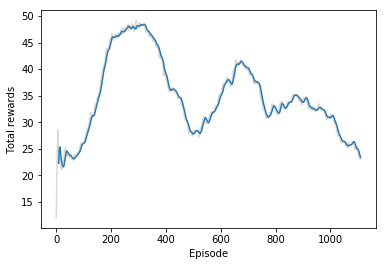

In [37]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

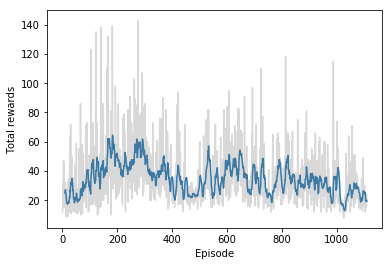

In [38]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

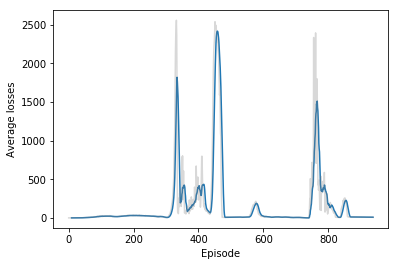

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.